<a href="https://colab.research.google.com/github/FrancoisGuillem/colab/blob/master/gan_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from matplotlib import pyplot as plt
import numpy as np
from __future__ import absolute_import, division, print_function, unicode_literals
from google.colab import drive

# Install TensorFlow
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf

def preprocess_x(x):
  return (np.expand_dims(x, 3) - 127.5) / 127.5

mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = preprocess_x(x_train), preprocess_x(x_test)

TensorFlow 2.x selected.
11493376/11490434 [==============================] - 0s 0us/step


In [0]:
# Hyperparameters
batchsize = 64
dim_latent_space = 128
learning_rate = 0.0005

# Useful functions
def one_hot(labels):
  return tf.keras.utils.to_categorical(labels, 10)

def generate_fake_imgs(labels):
  N = len(labels)
  noise = np.random.normal(size=[N, dim_latent_space])
  labels_one_hot = one_hot(labels)
  return generator.predict(np.hstack([noise, labels_one_hot])), labels_one_hot

y_train_hot = one_hot(y_train)

def sample_true_imgs(N):
  idx_true_imgs = np.random.randint(0, 60000, N)
  return x_train[idx_true_imgs], y_train_hot[idx_true_imgs]

def minibatch(N):
  img_gen, labels_gen = generate_fake_imgs(np.random.randint(10, size=N // 2))
  img_true, labels_true = sample_true_imgs(N // 4)
  labels_false = one_hot(np.random.randint(10, size=N // 4))
  y = np.hstack([np.random.binomial(1, 0.95, N//4), np.random.binomial(1, 0.05, N//2 + N // 4)])

  return np.vstack([img_true, img_true, img_gen]), np.vstack([labels_true, labels_false, labels_gen]), y

In [0]:
generator = tf.keras.Sequential([
  tf.keras.layers.Dense(128 * 7 * 7, input_shape=(dim_latent_space + 10,)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Reshape((7, 7, 128)),
  tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(1, 1, padding='same', activation="tanh")
])

generator.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 6272)              871808    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 6272)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 14, 14, 128)       409728    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 28, 28, 128)       409728    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 128)     

In [0]:
discriminator_cnn_part = tf.keras.Sequential([
  tf.keras.layers.Conv2D(32, [5, 5], input_shape=[28,28, 1]),
  tf.keras.layers.ReLU(),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPool2D(2, strides=2),
  tf.keras.layers.Conv2D(64, [5, 5]),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPool2D(2, strides=2),
  tf.keras.layers.Flatten(),
])

labels_discriminator = tf.keras.Input((10,))

h = tf.keras.layers.concatenate([discriminator_cnn_part.outputs[0], labels_discriminator])
h = tf.keras.layers.Dense(200, activation="relu")(h)
h = tf.keras.layers.Dropout(0.5)(h)
h = tf.keras.layers.Dense(100, activation="relu", input_shape=[210])(h)
pred = tf.keras.layers.Dense(1, activation="sigmoid")(h)

discriminator = tf.keras.Model(inputs=[discriminator_cnn_part.inputs, labels_discriminator], outputs=pred)

optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)

discriminator.compile(optimizer=optimizer,  
              loss='binary_crossentropy',
              metrics=['accuracy'])

discriminator.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
conv2d_4_input (InputLayer)     [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 24, 24, 32)   832         conv2d_4_input[0][0]             
__________________________________________________________________________________________________
re_lu_2 (ReLU)                  (None, 24, 24, 32)   0           conv2d_4[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 24, 24, 32)   128         re_lu_2[0][0]                    
____________________________________________________________________________________________

In [0]:
output = discriminator([generator.outputs, discriminator.inputs[1]])

gan = tf.keras.Model(inputs=[generator.inputs, discriminator.inputs[1]], outputs=output, name="gan")

discriminator.trainable = False

optimizer = tf.keras.optimizers.RMSprop(lr=learning_rate)
gan.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

gan.summary()

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: input_2:0
Model: "gan"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dense_20_input (InputLayer)     [(None, 138)]        0                                            
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 6272)         871808      dense_20_input[0][0]             
__________________________________________________________________________________________________
leaky_re_lu_3 (LeakyReLU)       (None, 6272)         0           dense_20[0][0]                   
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 7, 7, 128)    0           lea

In [0]:
# Restore networks
imgs, labels, y = minibatch(2)
discriminator.trainable = True
discriminator.train_on_batch([imgs, labels], y)
discriminator.trainable = False

labels_gen = one_hot(np.random.randint(10, size=2))
noise = np.random.normal(size=[2, dim_latent_space])
y = np.ones(2)
gan.train_on_batch([np.hstack([noise, labels_gen]), labels_gen], y)

drive.mount('/content/drive')
discriminator.load_weights('/content/drive/My Drive/Colab Notebooks/gan_discr_mnist')
generator.load_weights('/content/drive/My Drive/Colab Notebooks/gan_gen_mnist')
gan.load_weights('/content/drive/My Drive/Colab Notebooks/gan_mnist')



Mounted at /content/drive


In [0]:
# Initial training of discriminator

imgs, labels, y = minibatch(20000)

discriminator.trainable = True

discriminator.fit([imgs, labels], y, batch_size=100, epochs=1)
discriminator.trainable = False


Train on 20000 samples
Epoch 1/10
20000/20000 [==============================] - 3s 137us/sample - loss: 0.4704 - accuracy: 0.7254
Epoch 2/10
 8900/20000 [============>.................] - ETA: 1s - loss: 0.4517 - accuracy: 0.7339

KeyboardInterrupt: ignored

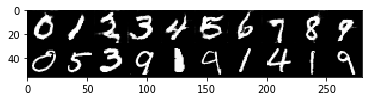

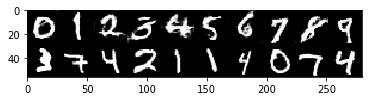

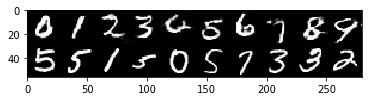

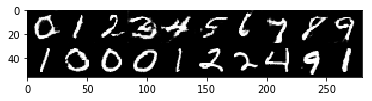

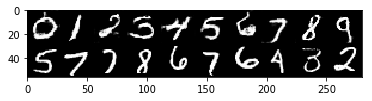

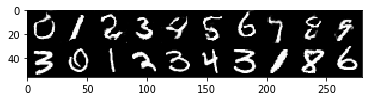

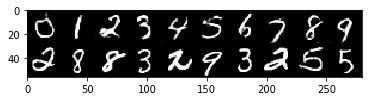

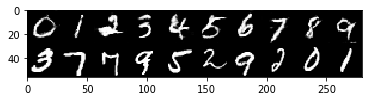

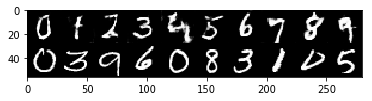

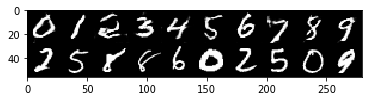

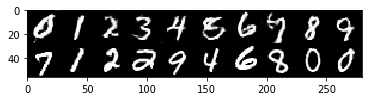

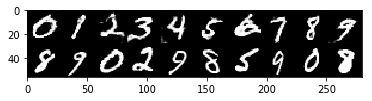

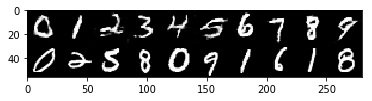

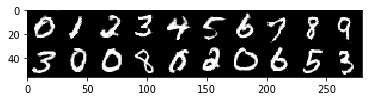

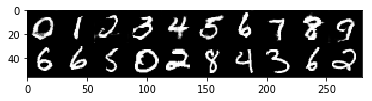

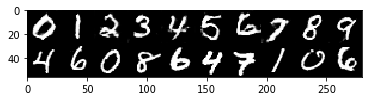

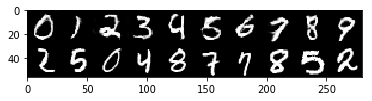

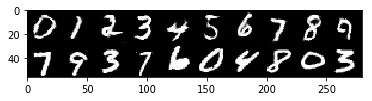

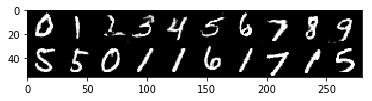

KeyboardInterrupt: ignored

In [0]:
discr_accuracy = []
gen_accuracy = []
for i in range(10000):
  for _ in range(1):
    imgs, labels, y = minibatch(batchsize)
    
    # train discriminator
    discriminator.trainable = True
    logloss, acc_discr = discriminator.train_on_batch([imgs, labels], y)   
    discriminator.trainable = False

  discr_accuracy.append(acc_discr)

  # train generator
  labels_gen = one_hot(np.random.randint(10, size=batchsize))
  noise = np.random.normal(size=[batchsize, dim_latent_space])
  
  y = np.ones(batchsize)
  logloss, acc_gen = gan.train_on_batch([np.hstack([noise, labels_gen]), labels_gen], y)
  gen_accuracy.append(acc_gen)

  # Generate some images
  if i % 50 == 0:
    generated_images_test, labels = generate_fake_imgs(np.arange(10))
    generated_images_test = np.squeeze(generated_images_test * 127.5 + 127.5).astype(np.uint8)

    image_test_sample = np.squeeze(x_train[np.random.randint(0, 60000, 10),:] * 127.5+127.5).astype(np.uint8)


    plt.imshow(np.vstack([np.hstack(generated_images_test), np.hstack(image_test_sample)]), interpolation='nearest', cmap='gray')
    plt.show()

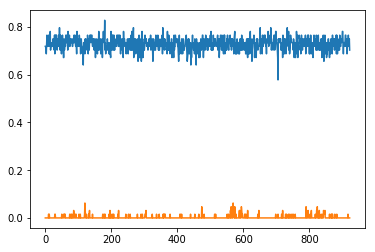

In [0]:
plt.plot(discr_accuracy)
plt.plot(gen_accuracy)

In [0]:
drive.mount('/content/drive')
discriminator.save_weights('/content/drive/My Drive/Colab Notebooks/gan_discr_mnist', save_format='tf')
gan.save_weights('/content/drive/My Drive/Colab Notebooks/gan_mnist', save_format='tf')
generator.save_weights('/content/drive/My Drive/Colab Notebooks/gan_gen_mnist', save_format='tf')

Mounted at /content/drive


In [0]:
# Check that discriminator is healthy
img, label = sample_true_imgs(1)
print(label)

for i in range(10):
  print(discriminator.predict([img, one_hot([i])]))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


KeyboardInterrupt: ignored

In [0]:
for _ in range(10):
  noise = np.random.normal(size=[1, dim_latent_space])
  imgs = [np.squeeze(generator.predict(np.hstack([noise, one_hot([i])])) * 127.5 + 127.5).astype(np.uint8) for i in range(10)]
  plt.imshow(np.hstack(imgs), interpolation='nearest', cmap='gray')
  plt.show()

## Analysis of latent space

We try to identify how to manipulate latent space to reduce or increase the thickness of the generated numbers

In [0]:
noise = np.random.normal(size=[10000, dim_latent_space])
labels = one_hot(np.random.randint(10, size=10000))
imgs = generator.predict(np.hstack([noise, labels]))
avg_ink = np.mean(imgs[:, 0:14, 0:14, :], axis = (1,2,3)) + \
  -np.mean(imgs[:, 0:14, 14:28, :], axis = (1,2,3)) +\
  -np.mean(imgs[:, 14:28, 0:14, :], axis = (1,2,3)) + \
  np.mean(imgs[:, 14:28, 14:28, :], axis = (1,2,3))
avg_ink = (avg_ink - avg_ink.mean()) / avg_ink.std() 

In [0]:
linear_model = tf.keras.models.Sequential([tf.keras.layers.Dense(1, input_shape=(dim_latent_space,))])
linear_model.compile(optimizer="adam", loss="mse")
linear_model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 1)                 129       
Total params: 129
Trainable params: 129
Non-trainable params: 0
_________________________________________________________________


In [0]:
linear_model.fit(noise, avg_ink, batch_size=100, epochs=20)

Train on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 0s 47us/sample - loss: 1.9852
Epoch 2/20
10000/10000 [==============================] - 0s 28us/sample - loss: 0.9312
Epoch 3/20
10000/10000 [==============================] - 0s 23us/sample - loss: 0.4969
Epoch 4/20
10000/10000 [==============================] - 0s 23us/sample - loss: 0.3383
Epoch 5/20
10000/10000 [==============================] - 0s 23us/sample - loss: 0.2858
Epoch 6/20
10000/10000 [==============================] - 0s 27us/sample - loss: 0.2692
Epoch 7/20
10000/10000 [==============================] - 0s 23us/sample - loss: 0.2644
Epoch 8/20
10000/10000 [==============================] - 0s 23us/sample - loss: 0.2627
Epoch 9/20
10000/10000 [==============================] - 0s 22us/sample - loss: 0.2623
Epoch 10/20
10000/10000 [==============================] - 0s 25us/sample - loss: 0.2623
Epoch 11/20
10000/10000 [==============================] - 0s 24us/sample - loss: 0.2625
Epoch 1

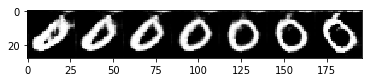

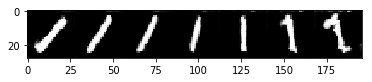

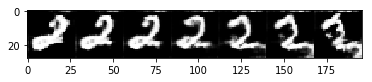

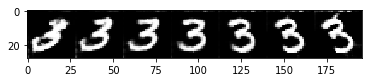

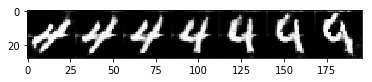

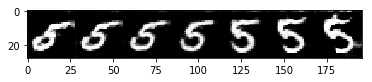

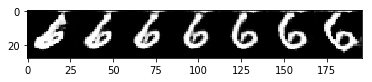

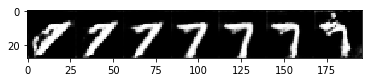

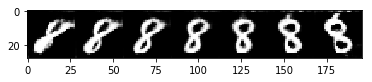

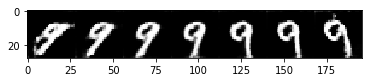

In [0]:
thickness_vector = np.squeeze(linear_model.layers[0].get_weights()[0])

noise = np.random.normal(size=[1, dim_latent_space])
noise = np.zeros(shape=(1, dim_latent_space))
for i in range(10):
  labels = one_hot([i])
  imgs = [
          np.squeeze(generator.predict(np.hstack([noise - 4 * thickness_vector, labels]))),
          np.squeeze(generator.predict(np.hstack([noise - 2 * thickness_vector, labels]))),
          np.squeeze(generator.predict(np.hstack([noise - 1 * thickness_vector, labels]))),
          np.squeeze(generator.predict(np.hstack([noise, labels]))) ,
          np.squeeze(generator.predict(np.hstack([noise + 1 * thickness_vector, labels]))),
          np.squeeze(generator.predict(np.hstack([noise + 2 * thickness_vector, labels]))),
          np.squeeze(generator.predict(np.hstack([noise + 4 * thickness_vector, labels])))
          
  ]

  imgs = (np.hstack(imgs) * 127.5 + 127.5).astype(np.uint8)
  plt.imshow(imgs, interpolation='nearest', cmap='gray')
  plt.show()


-0.14717622